In [1]:
# Constants

months_list = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 
               'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
invalid_value = -999
data_timezone = 'America/Sao_Paulo'

In [2]:
# Imports

import os
import math

from datetime import timezone, datetime

import numpy as np
import pandas as pd
import geopandas as gpd
import pysal
import contextily
import xarray
import datashader
from geopy import distance
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns; sns.set()
from pointpats import centrography


/Users/josebraz/opt/anaconda3/lib/python3.9/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(


In [3]:
# caches
orbital_cache = {}

In [4]:
# Get all csv files in the burn_folder

directory = os.getcwd()
burn_folder = os.path.join(directory, "data")
csv_files = os.listdir(burn_folder)

print("Reading {} files...".format(len(csv_files)))

column_types = {
    'precipitacao': 'float32',
    'riscofogo': 'float32',
    'latitude': 'float64',
    'longitude': 'float64',
    'frp': 'float64'
}

# Create the DataFrame from csv
df: pd.DataFrame = pd.concat(
    [pd.read_csv(os.path.join(burn_folder, f), parse_dates=["datahora"], dtype=column_types) for f in csv_files], 
    ignore_index=True
  )

# optimize data and setup types
print("Optimizing dataframe {}...".format(df.shape))
df['diasemchuva'] = df['diasemchuva'].fillna(invalid_value).astype("int16")
df.loc[df.riscofogo == invalid_value, 'riscofogo'] = 0
df['riscofogo'] = df['riscofogo'].fillna(0).astype("bool")
df['satelite'] = df['satelite'].str.upper().astype("category")
df['pais'] = df['pais'].str.upper().astype("category")
df['estado'] = df['estado'].str.upper().astype("category")
df['municipio'] = df['municipio'].str.upper().astype("category")
df['bioma'] = df['bioma'].str.upper().astype("category")

print('Data frame optimized with final size: {}'.format(df.memory_usage(deep=True).sum()))

print('Setting up date columns...')
df['datahora'] = df['datahora'].dt.tz_localize(timezone.utc).dt.tz_convert(data_timezone)
df['date'] = df['datahora'].dt.date
df['hora'] = df['datahora'].dt.time
df['dia'] = df['datahora'].dt.day
df['mes'] = df['datahora'].dt.month
df['ano'] = df['datahora'].dt.year

df.info()

Reading 300 files...
Optimizing dataframe: (43782758, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43782758 entries, 0 to 43782757
Data columns (total 17 columns):
 #   Column        Dtype                            
---  ------        -----                            
 0   datahora      datetime64[ns, America/Sao_Paulo]
 1   satelite      category                         
 2   pais          category                         
 3   estado        category                         
 4   municipio     category                         
 5   bioma         category                         
 6   diasemchuva   int16                            
 7   precipitacao  float32                          
 8   riscofogo     bool                             
 9   latitude      float64                          
 10  longitude     float64                          
 11  frp           float64                          
 12  date          object                           
 13  hora          object       

In [5]:
# Processamento dos satelites

# Muitos satélites podem ser simplificados
satelite_map = {
  'NPP-375D': 'Suomi NPP',
  'NPP-375': 'Suomi NPP',
  'AQUA_M-T': 'AQUA',
  'AQUA_M-M': 'AQUA',
  'AQUA_M': 'AQUA',
  'TERRA_M-T': 'TERRA',
  'TERRA_M-M': 'TERRA',
  'TERRA_M': 'TERRA',
  'NOAA-18D': 'NOAA-18',
  'NOAA-19D': 'NOAA-19',
  'NOAA-16N': 'NOAA-16',
  'NOAA-15D': 'NOAA-15',
  'NOAA-12D': 'NOAA-12'
}
df['simp_satelite'] = df['satelite'].map(satelite_map).fillna(df['satelite']).astype("category")

# cada satélite tem um sensor
satelite_sensors = {
  'NPP-375': 'VIIRS',
  'NOAA-20': 'VIIRS',
  'GOES-16': 'ABI',
  'GOES-13': 'GOES I-M',
  'GOES-12': 'GOES I-M',
  'GOES-10': 'GOES I-M',
  'GOES-08': 'GOES I-M',
  'AQUA': 'MODIS',
  'TERRA': 'MODIS',
  'AQUA': 'MODIS',
  'TERRA': 'MODIS',
  'NOAA-18': 'AVHRR-3',
  'NOAA-19': 'AVHRR-3',
  'NOAA-17': 'AVHRR-3',
  'NOAA-16': 'AVHRR-3',
  'NOAA-15': 'AVHRR-3',
  'NOAA-14': 'AVHRR',
  'NOAA-12': 'AVHRR',
  'MSG-03': 'SEVIRI', 
  'MSG-02': 'SEVIRI',
  'METOP-B': 'AVHRR-3', 
  'METOP-C': 'AVHRR-3',
  'ATSR': 'ATSR',
  'TRMM': 'VIRS'
}

df['sensor'] = df['simp_satelite'].map(satelite_sensors).astype("category")

In [95]:
# variaveis derivadas dos dados
all_satellites = df['satelite'].value_counts().index.values
simp_satellites = df['simp_satelite'].value_counts().index.values
actual_satellites = df[(df['ano'] == 2022)]['simp_satelite'].value_counts().loc[lambda x : x > 0].index.values

print('Original satellites size:', len(all_satellites.tolist()))
print('Simplified satellites size:', len(simp_satellites.tolist()))

Original satellites size: 32
Simplified satellites size: 22


TypeError: can only concatenate list (not "int") to list

In [92]:
from matplotlib.patches import Rectangle

def plot_colortable(colors, *, ncols=4) -> plt.Figure:
    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

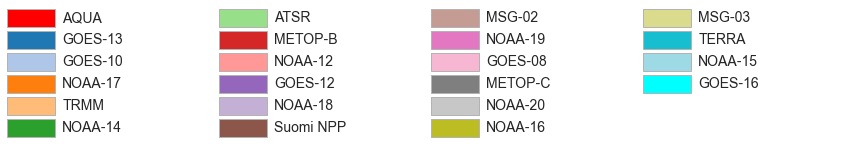

In [112]:
# Escolher cores boas paras os satélites ajuda na análise
# Ai sempre vamos usar as mesmas cores, criando gráficos 
# consistentes entre sí

import random

random.seed(43)

simp_satellites_rand = simp_satellites.tolist()
random.shuffle(simp_satellites_rand)
cmap = plt.cm.get_cmap('tab20', len(simp_satellites_rand))
satellites_colors = {}
for (i, satelite) in enumerate(simp_satellites_rand):
    satellites_colors[satelite] = cmap(i)

satellites_colors[simp_satellites_rand[0]] = (1.0, 0.0, 0.0, 1.0)
satellites_colors[simp_satellites_rand[-1]] = (0.0, 1.0, 1.0, 1.0)

plot_colortable(satellites_colors)
plt.show()

In [155]:
# Pastas dos shapes
aux_folder = os.path.join(directory, "aux")
uf_folder = os.path.join(aux_folder, "ibge/BR_UF_2021")
municipios_folder = os.path.join(aux_folder, "ibge/BR_Municipios_2021")
biomas_folder = os.path.join(aux_folder, "ibge/Biomas_250mil")

estados_shape: gpd.GeoDataFrame = gpd.read_file(uf_folder + '/BR_UF_2021.shp')
municipios_shape: gpd.GeoDataFrame = gpd.read_file(municipios_folder + '/BR_Municipios_2021.shp')
biomas_shape: gpd.GeoDataFrame = gpd.read_file(biomas_folder + '/lm_bioma_250.shp')

# processamento para ser compatível com os dados do INPE
estados_shape['NM_UF'] = estados_shape['NM_UF'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
municipios_shape['NM_MUN'] = municipios_shape['NM_MUN'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
biomas_shape['Bioma'] = biomas_shape['Bioma'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# falta as áreas dos estados no dado do ibge, bora garimpar elas
estados_shape = pd.merge(
    left=estados_shape,
    right=municipios_shape.groupby(['SIGLA'])['AREA_KM2'].sum(),
    left_on=['SIGLA'],
    right_on=['SIGLA']
)

# dados do ibge também https://brasilemsintese.ibge.gov.br/territorio.html
biomas_shape['AREA_KM2'] = biomas_shape['Bioma'].map({
    'Amazonia': 4196943,
    "Cerrado": 2036448,
    "Mata Atlantica": 1110182,
    "Caatinga": 844453,
    "Pampa": 176496,
    "Pantanal": 150355
})

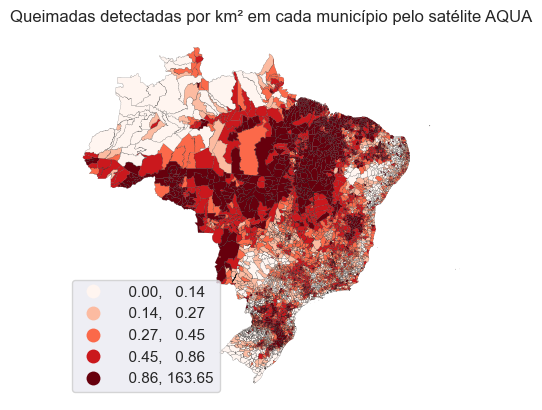

In [162]:
reference_df = df[(df.satelite == 'AQUA_M-T')]
municipios_counts = reference_df.groupby(['municipio'])['municipio'].count().rename('count').to_frame()
municipios_counts_with_shape = gpd.GeoDataFrame(
    pd.merge(
        left=municipios_counts,
        right=municipios_shape,
        left_on=['municipio'],
        right_on=['NM_MUN'],
        how='inner'
    )
)

municipios_counts_with_shape['count_by_km2'] = municipios_counts_with_shape['count'] / municipios_counts_with_shape['AREA_KM2']

ax = municipios_counts_with_shape.plot(
    column='count_by_km2',
    scheme="Quantiles",
    cmap="Reds",
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={'loc': 'lower left'}
)
ax.set_title(u'Queimadas detectadas por km\u00b2 em cada município pelo satélite AQUA')
ax.set_axis_off()

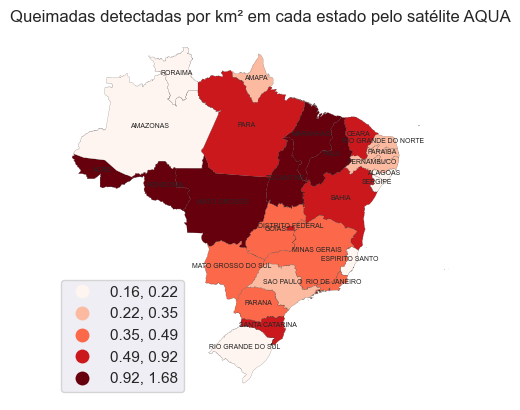

In [163]:
reference_df = df[(df.satelite == 'AQUA_M-T')]
estados_counts = reference_df.groupby(['estado'])['estado'].count().rename('count').to_frame()
estado_counts_with_shape = gpd.GeoDataFrame(
    pd.merge(
        left=estados_counts,
        right=estados_shape,
        left_on=['estado'],
        right_on=['NM_UF'],
        how='inner'
    )
)

estado_counts_with_shape['count_by_km2'] = estado_counts_with_shape['count'] / estado_counts_with_shape['AREA_KM2']

ax = estado_counts_with_shape.plot(
    column='count_by_km2',
    scheme="Quantiles",
    cmap="Reds",
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={'loc': 'lower left'}
)
estado_counts_with_shape.apply(
    lambda x: ax.annotate(text=x['NM_UF'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=5), 
    axis=1
)

ax.set_title(u'Queimadas detectadas por km\u00b2 em cada estado pelo satélite AQUA')
ax.set_axis_off()

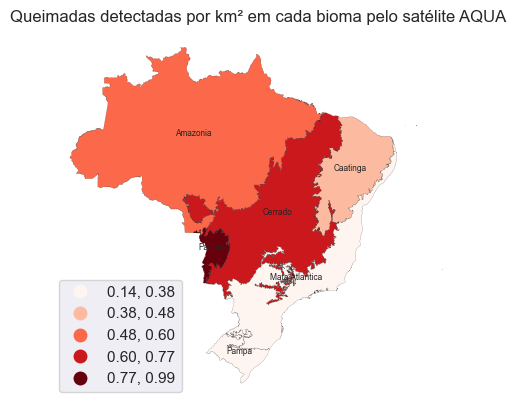

In [161]:
reference_df = df[(df.satelite == 'AQUA_M-T')]
bioma_counts = reference_df.groupby(['bioma'])['bioma'].count().rename('count').to_frame()
bioma_counts_with_shape = gpd.GeoDataFrame(
    pd.merge(
        left=bioma_counts,
        right=biomas_shape,
        left_on=['bioma'],
        right_on=['Bioma'],
        how='inner'
    )
)

bioma_counts_with_shape['count_by_km2'] = bioma_counts_with_shape['count'] / bioma_counts_with_shape['AREA_KM2']

ax = bioma_counts_with_shape.plot(
    column='count_by_km2',
    scheme="Quantiles",
    cmap="Reds",
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={'loc': 'lower left'}
)
bioma_counts_with_shape.apply(
    lambda x: ax.annotate(text=x['Bioma'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), 
    axis=1
)
ax.set_title(u'Queimadas detectadas por km\u00b2 em cada bioma pelo satélite AQUA')
ax.set_axis_off()

<AxesSubplot:title={'center':'Quantitativo de ano de 2021'}, xlabel='date'>

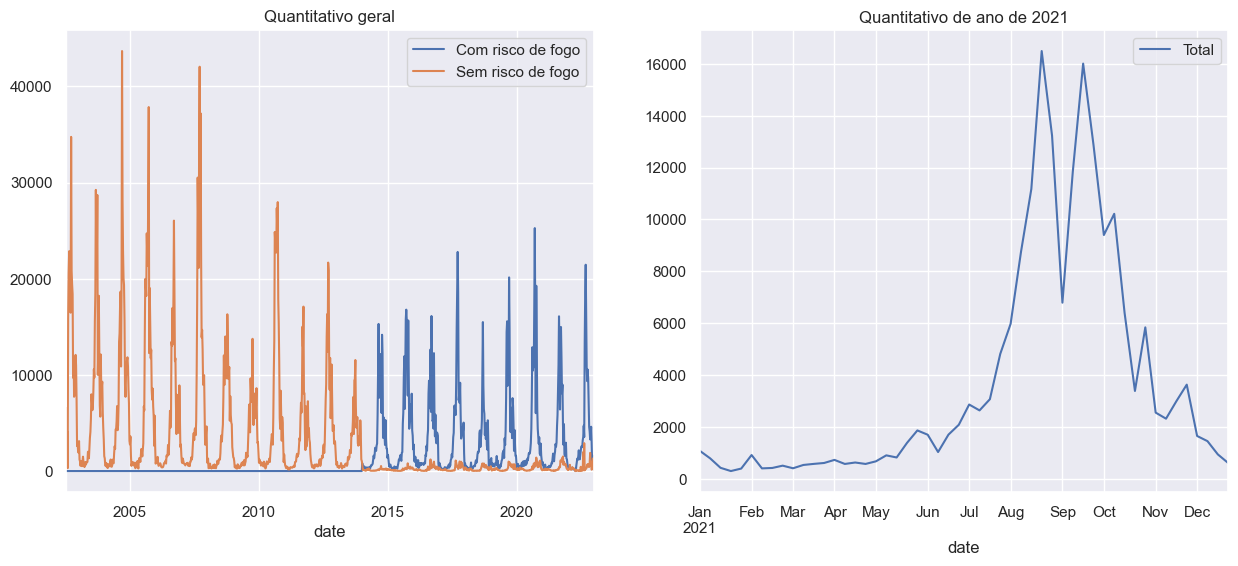

In [475]:
# analise quantitativa dos dados com relacao a flag risco de fogo
reference_df = df[(df.satelite == 'AQUA_M-T')]

date_risco_counts = reference_df.loc[(df.riscofogo)].groupby(['date'])['date'].count()
date_risco_counts.name = 'Com risco de fogo'
date_sem_risco_counts = reference_df.loc[(df.riscofogo == False)].groupby(['date'])['date'].count()
date_sem_risco_counts.name = 'Sem risco de fogo'

daily_df = pd.concat([date_risco_counts, date_sem_risco_counts], axis=1).fillna(0).astype('int')
daily_df.index = pd.to_datetime(daily_df.index)
daily_df['Total'] = daily_df.iloc[:, 0] + daily_df.iloc[:, 1]
weekly_df = daily_df.resample('W').sum()

fig, axs = plt.subplots(1, 2, figsize=(15,6))
weekly_df.drop(['Total'], axis=1).plot(ax=axs[0], title='Quantitativo geral')
weekly_df.loc['2021'].plot(y='Total', ax=axs[1], title='Quantitativo de ano de 2021')

In [ ]:
import matplotlib.ticker as mtick
def bar_limited(serie: pd.Series, ax: plt.Axes=plt.axes(), min_percent=0.02, title: str='', xlabel: str='', ylabel: str=''):
    pie_temp = serie.loc[lambda x : x > 0]
    total = pie_temp.sum()
    greatter = pie_temp.loc[lambda x : x/total >= min_percent].map(lambda x : x/total * 100)
    little = pie_temp.loc[lambda x : x/total < min_percent]
    print('outros:', little)
    pd.concat([greatter, pd.Series(data=[little.sum()/total * 100], index=['Outros'])]).plot.bar(
        y='Detecções',
        ax=ax,
        title=title
    )
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

outros: NOAA-15    863266
GOES-13    605870
NOAA-16    599411
METOP-B    338016
GOES-10    290127
MSG-03     280700
MSG-02     205509
ATSR       148199
TRMM        90204
METOP-C     58131
NOAA-17     55451
GOES-08     42081
NOAA-14     31069
Name: simp_satelite, dtype: int64
outros: NOAA-19    64491
NOAA-18    41782
MSG-03     18175
METOP-B     8072
METOP-C     5467
Name: simp_satelite, dtype: int64


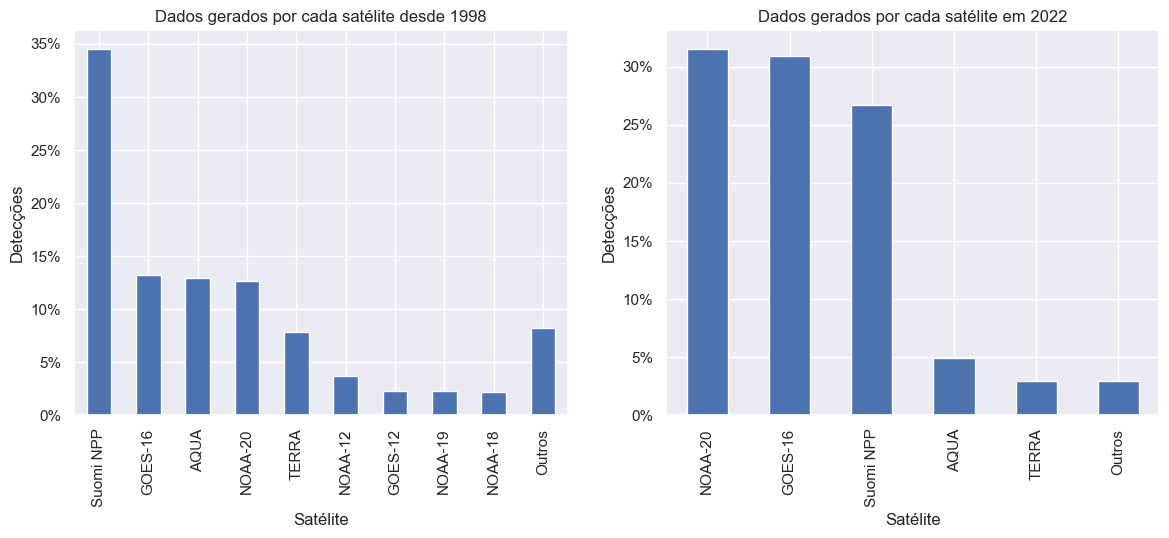

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

bar_limited(
    df["simp_satelite"].value_counts(),
    ax=axs[0],
    title='Dados gerados por cada satélite desde 1998',
    xlabel='Satélite',
    ylabel='Detecções'
)

bar_limited(
    df[(df['ano'] == 2022)]["simp_satelite"].value_counts(),
    ax=axs[1],
    title='Dados gerados por cada satélite em 2022',
    xlabel='Satélite',
    ylabel='Detecções'
)

outros: SEVIRI    486209
ATSR      148199
VIRS       90204
Name: sensor, dtype: int64
outros: SEVIRI    18175
Name: sensor, dtype: int64


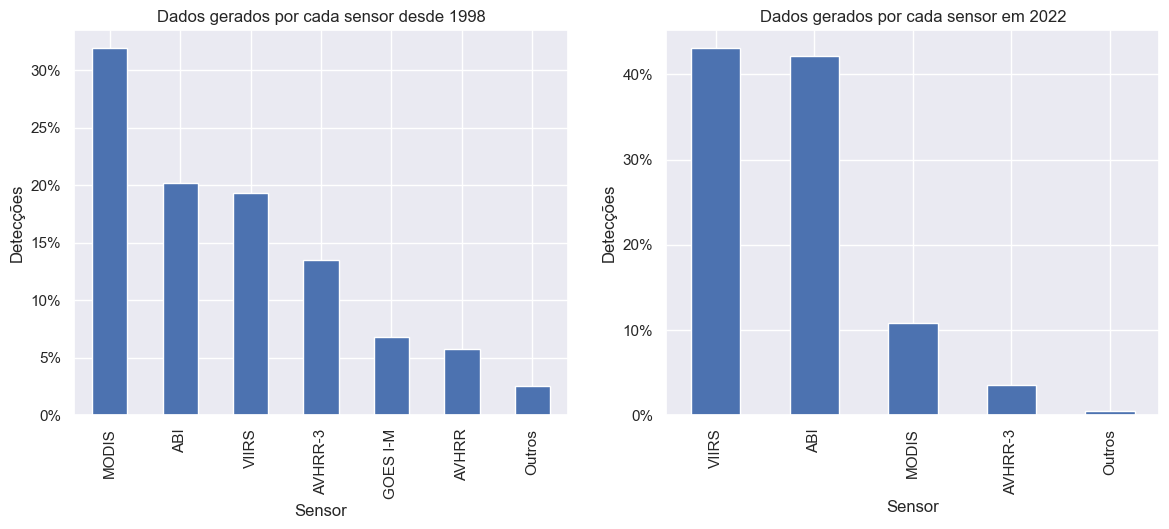

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

bar_limited(
    df["sensor"].value_counts(),
    ax=axs[0],
    title='Dados gerados por cada sensor desde 1998',
    xlabel='Sensor',
    ylabel='Detecções'
)

bar_limited(
    df[(df['ano'] == 2022)]["sensor"].value_counts(),
    ax=axs[1],
    title='Dados gerados por cada sensor em 2022',
    xlabel='Sensor',
    ylabel='Detecções'
)

Text(0.5, 0, 'Horário')

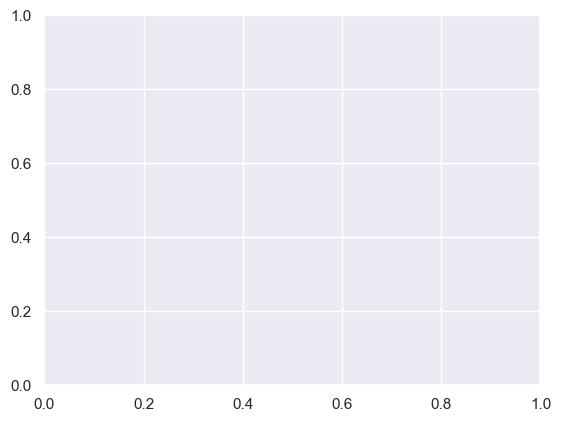

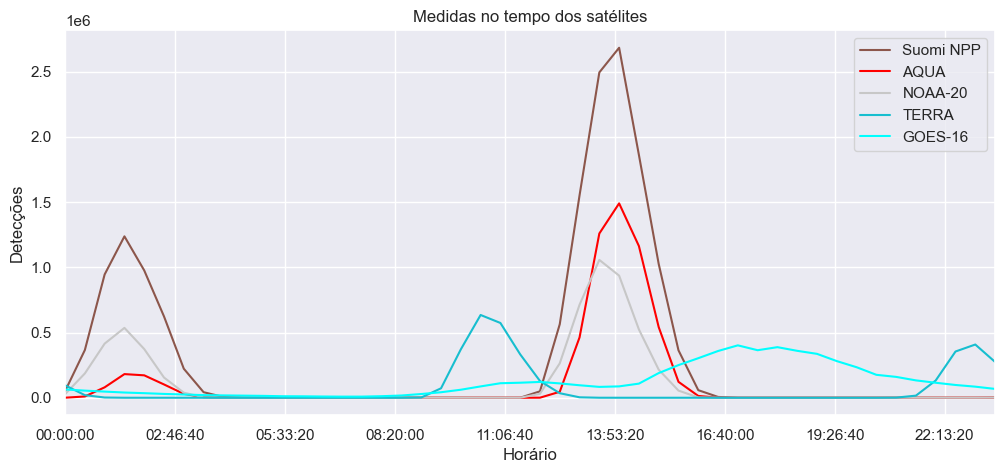

In [131]:
# analise do horários das medicoes dos satelites
from datetime import datetime, timedelta
import matplotlib.ticker as plticker
import matplotlib.dates as mdates

def time_measure_dist(satelite='AQUA_M-T', ax: plt.Axes=plt.axes()):
  time_counts = df[(df["simp_satelite"] == satelite)].groupby(['hora'])['hora'].count()
  time_counts.index = pd.TimedeltaIndex(data=time_counts.index.astype('str'))
  if '00:00:00' not in time_counts.index:
    time_counts['00:00:00'] = 0
  if '23:59:59' not in time_counts.index:
    time_counts['23:59:59'] = 0
  time_counts = time_counts.resample('30min').sum().reindex().rename(satelite)
  time_counts.plot(ax=ax, c=satellites_colors[satelite], legend=True)

time_satellites = ['Suomi NPP', 'AQUA', 'NOAA-20', 'TERRA', 'GOES-16']
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for satelite in time_satellites:
  time_measure_dist(satelite, ax)

# ax.xaxis.set_major_locator(plticker.MaxNLocator(8))
ax.set_title("Medidas no tempo dos satélites")
ax.set_ylabel('Detecções')
ax.set_xlabel('Horário')

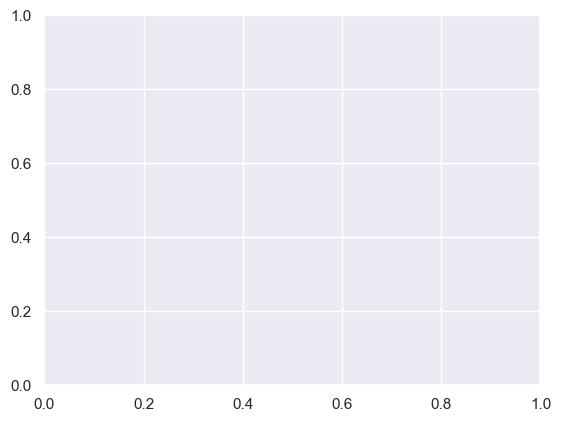

In [402]:
from pyorbital.orbital import Orbital

def draw_orbit(range: pd.DatetimeIndex, satelite: str, title: str = "", color = None, ax: plt.Axes=plt.axes()):
    global orbital_cache
    if satelite not in orbital_cache.keys():
        orbital_cache[satelite] = Orbital(satelite)
    orb = orbital_cache[satelite]
    
    data = pd.DataFrame(index=range)
    positions = data.index.map(orb.get_lonlatalt)
    data['longitude'] = positions.map(lambda x: x[0])
    data['latitude'] = positions.map(lambda x: x[1])
    if color is None:
        ax.plot(data['longitude'], data['latitude'], '-x', linewidth=1, markersize=5, label=satelite)
    else:
        ax.plot(data['longitude'], data['latitude'], '-x', linewidth=1, markersize=5, label=satelite, color=color)
        
    ax.legend(loc="lower left")
    ax.set_xlim([-85, -35])
    ax.set_ylim([-35, 5])
    ax.set_title(title)
    for index in [data.index[3], data.index[-3]]:
        ax.annotate(index.strftime("%H:%M"), (data['longitude'][index], data['latitude'][index]))



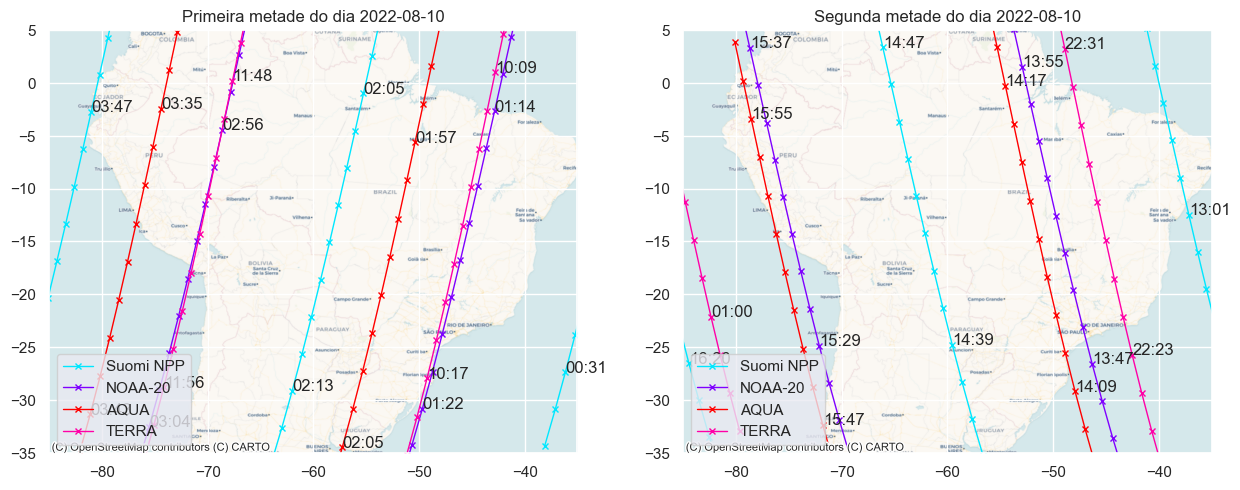

In [404]:
fig, axs=plt.subplots(1, 2, figsize=(15, 8))
day = "2022-08-10"
names = {
    "Suomi NPP": ["{} {}".format(day, "03:44"), "{} {}".format(day, "02:02"), "{} {}".format(day, "00:20")],
    "NOAA-20": ["{} {}".format(day, "02:53"), "{} {}".format(day, "01:11")],
    "AQUA": ["{} {}".format(day, "03:32"), "{} {}".format(day, "01:54")],
    "TERRA": ["{} {}".format(day, "11:45"), "{} {}".format(day, "10:06")],
}

names2 = {
    "Suomi NPP": ["{} {}".format(day, "14:36"), "{} {}".format(day, "16:17"), "{} {}".format(day, "12:58")],
    "NOAA-20": ["{} {}".format(day, "15:26"), "{} {}".format(day, "13:44")],
    "AQUA": ["{} {}".format(day, "14:06"), "{} {}".format(day, "15:44")],
    "TERRA": ["{} {}".format(day, "00:57"), "{} {}".format(day, "22:20")],
}

for (key, value) in names.items():
    for time in value:
        draw_orbit(
            range=pd.date_range(time, freq=timedelta(minutes=1), periods=14, tz=data_timezone),
            satelite=key,
            title="Primeira metade do dia {}".format(day),
            color=satellites_colors[key],
            ax=axs[0]
        )

for (key, value) in names2.items():
    for time in value:
        draw_orbit(
            range=pd.date_range(time, freq=timedelta(minutes=1), periods=14, tz=data_timezone),
            satelite=key,
            title="Segunda metade do dia {}".format(day),
            color=satellites_colors[key],
            ax=axs[1]
        )

handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0].legend(by_label.values(), by_label.keys(), loc="lower left")

handles, labels = axs[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[1].legend(by_label.values(), by_label.keys(), loc="lower left")

contextily.add_basemap(
    axs[0], 
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    axs[1], 
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.Voyager,
)

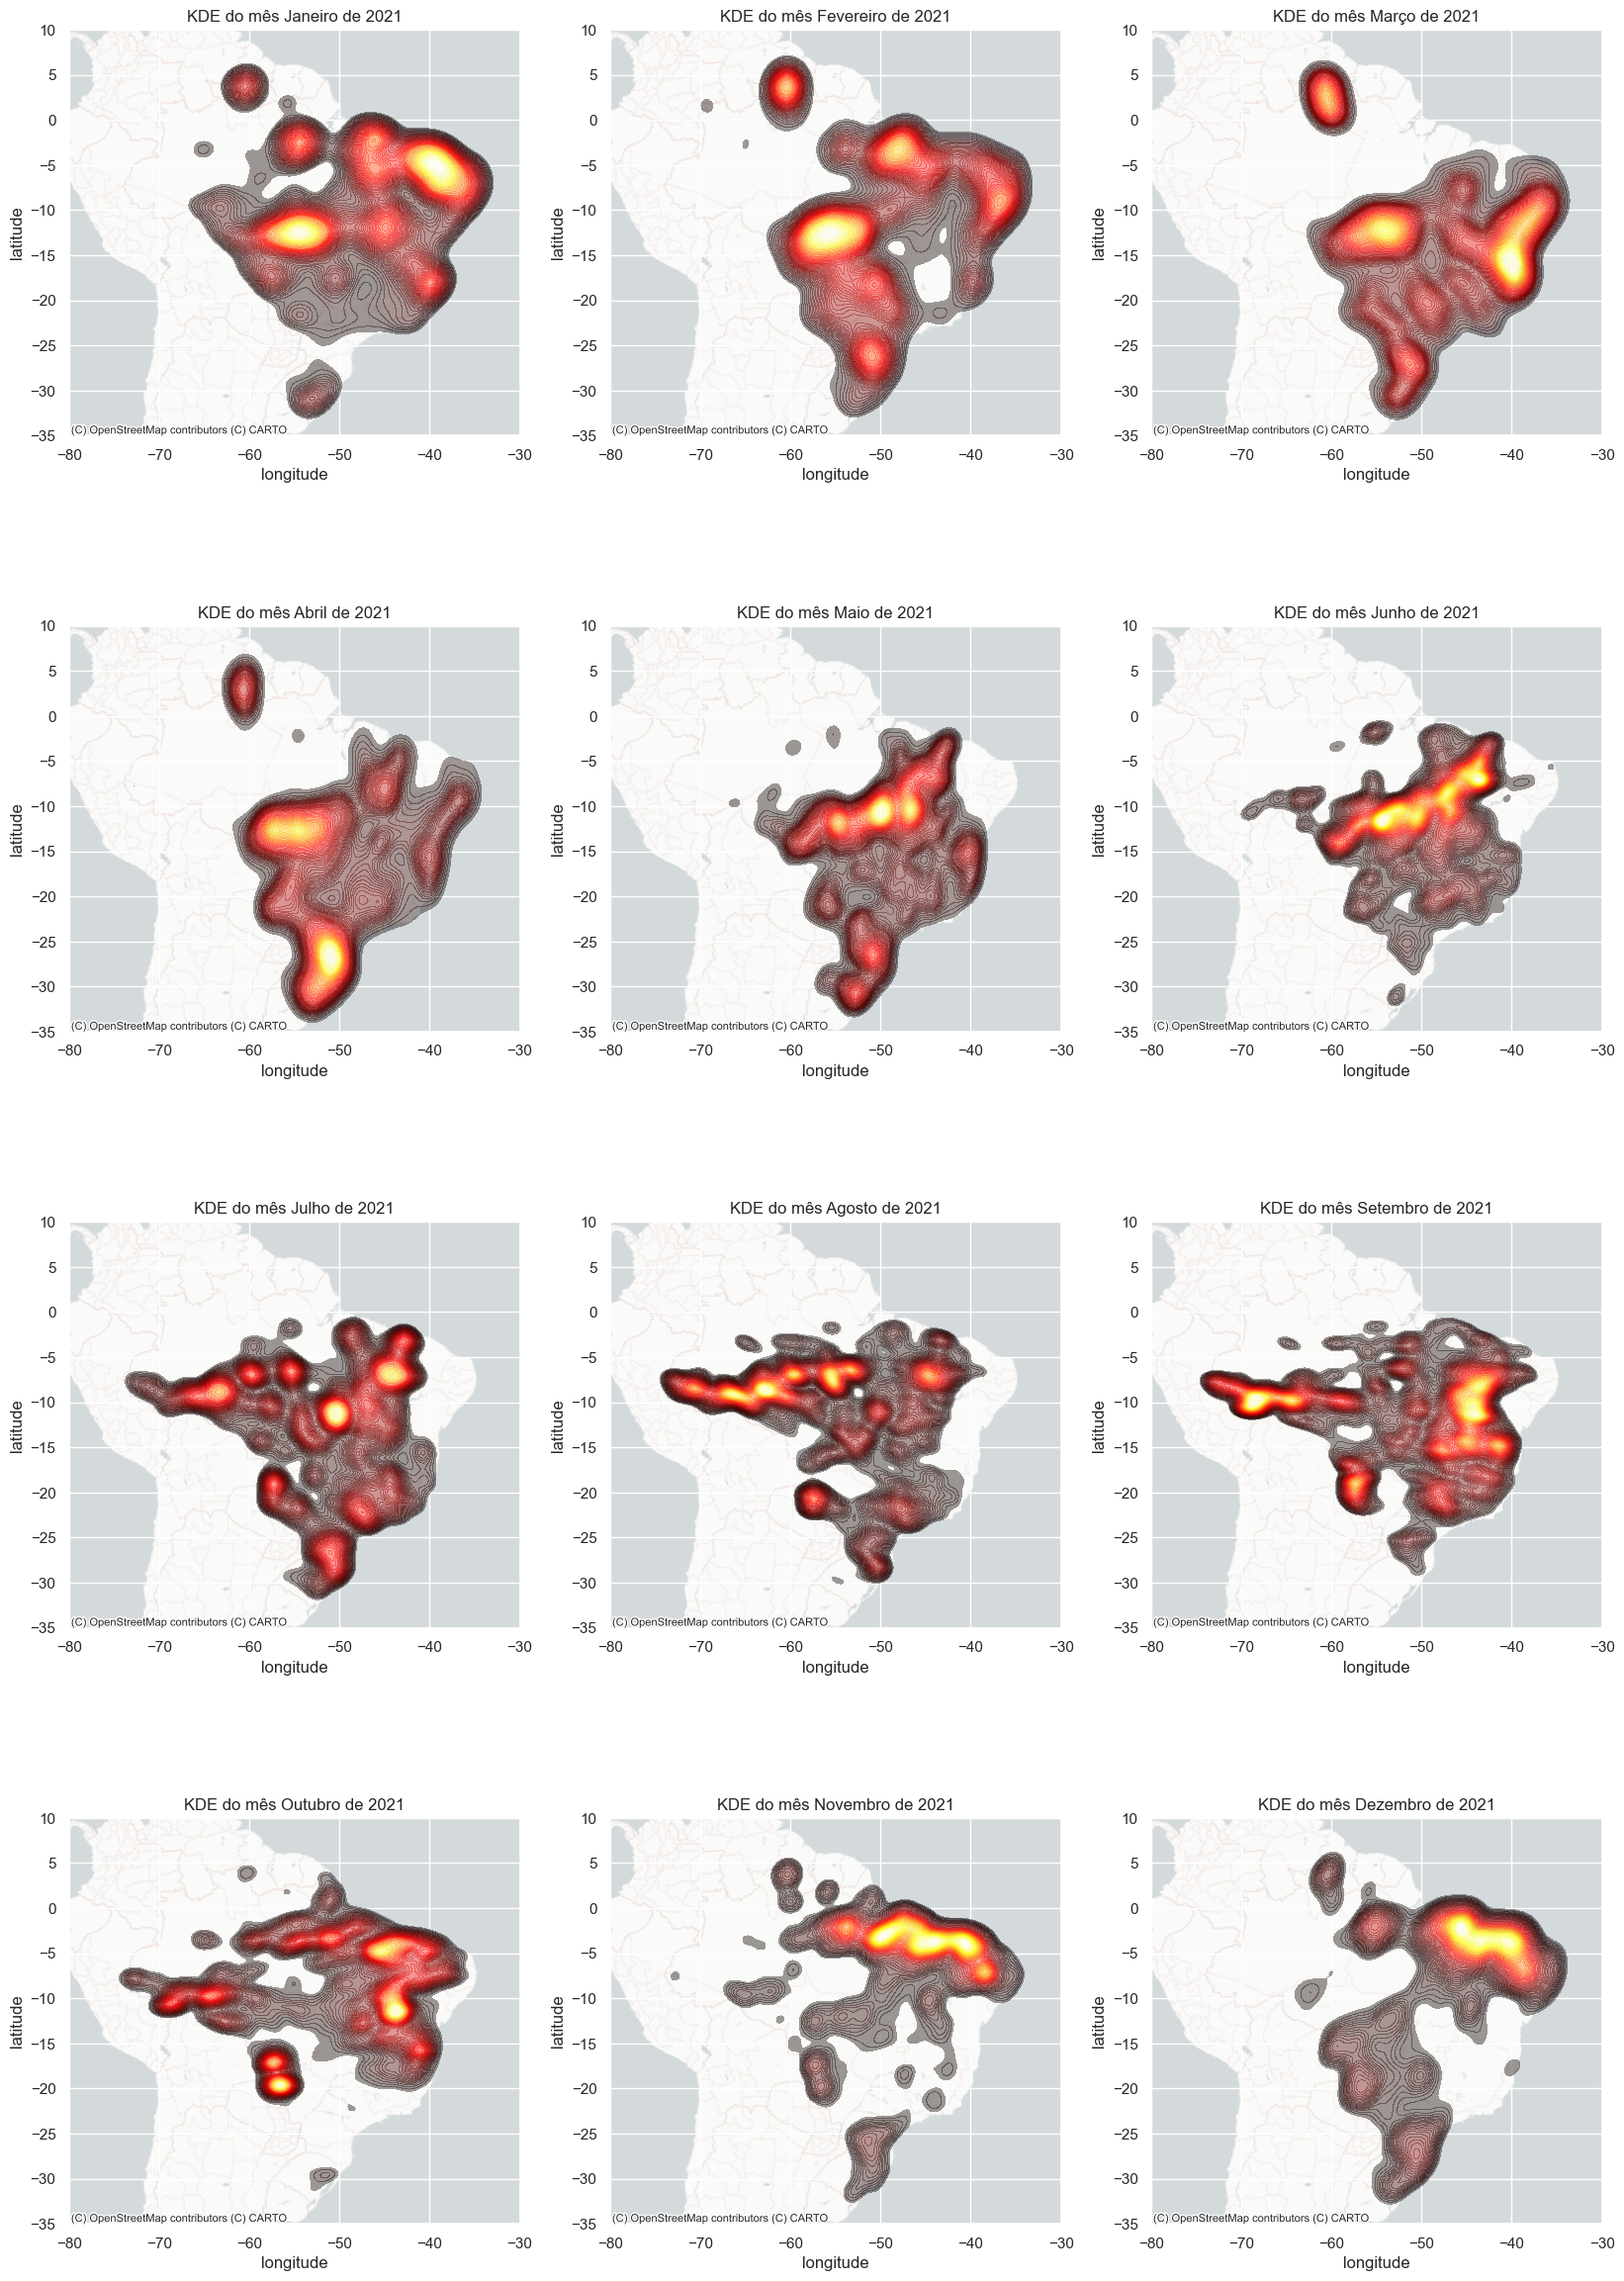

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(20, 30))
year = 2021
for i, ax in enumerate(axs.flat):
  month = i+1
  temp_df = reference_df.query('mes == {} and ano == {}'.format(month, year))
  ax.set_xlim([-80, -30])
  ax.set_ylim([-35, 10])
  sns.kdeplot(
      x=temp_df.longitude,
      y=temp_df.latitude,
      n_levels=50,
      fill=True,
      alpha=0.40,
      cmap="hot",
      bw_adjust=0.6,
      #cbar=True,
      ax=ax
  )
  ax.set_title("KDE do mês {} de {}".format(months_list[i], year))
  contextily.add_basemap(
      ax, 
      crs="EPSG:4326",
      source=contextily.providers.CartoDB.PositronNoLabels,
  )


In [408]:
# Utils functions

def sub_space(data: pd.DataFrame, min_lat: float, max_lat: float, min_lon: float, max_lon: float) -> pd.DataFrame:
    """Returns a sub data filtered by lat and lon boundary"""
    return data[(data['longitude'] >= min_lon) & (data['longitude'] <= max_lon) &
                (data['latitude'] >= min_lat) & (data['latitude'] <= max_lat)]

def split_by_range(data: pd.DataFrame, range: pd.DatetimeIndex, time_column='datahora') -> list[pd.DataFrame]:
    list = []
    if len(range) <= 1:
        return list
    for (i, current) in enumerate(range):
        if i < len(range) - 2:
            next = range[i+1]
            list.append(data[(data[time_column] >= current) & (data[time_column] < next)])
    return list

def grid_to_dataframe(grid: xarray.DataArray) -> pd.DataFrame:
    data = grid.to_pandas().unstack()
    return data.where(data > 0).dropna().reset_index().rename(columns={0: "value"}) 

def compute_grid(data: pd.DataFrame, min_lat: float, max_lat: float, 
                 min_lon: float, max_lon: float, 
                 aggr_dist = distance.Distance(kilometers=1)) -> xarray.DataArray:
    # calculate the grid (agregate)
    width_bottom = distance.distance((min_lat, min_lon), (min_lat, max_lon))
    width_top = distance.distance((max_lat, min_lon), (max_lat, max_lon))

    height_left = distance.distance((min_lat, min_lon), (max_lat, min_lon))
    height_right = distance.distance((min_lat, max_lon), (max_lat, max_lon))

    width = max(width_top, width_bottom)
    height = max(height_left, height_right)

    cvs = datashader.Canvas(
        plot_width=int(width/aggr_dist), 
        plot_height=int(height/aggr_dist),
        x_range=(min_lon, max_lon),
        y_range=(min_lat, max_lat)
    )
    return cvs.points(data, x="longitude", y="latitude")

Empty DataFrame
Columns: [longitude, latitude, value]
Index: []

/Users/josebraz/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/josebraz/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/josebraz/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
/Users/josebraz/opt/anaconda3/lib/python3.9/site-packages/geopandas/array.py:275: ShapelyDeprecationWar

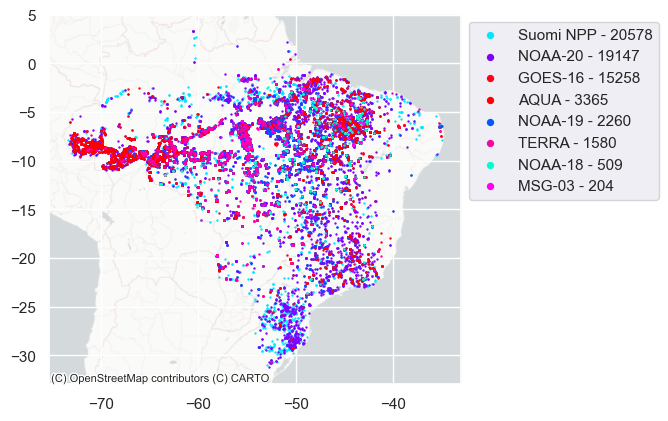

In [409]:
def show_satelites(data: pd.DataFrame):
    fig, ax=plt.subplots()
    satelites_data = data['simp_satelite'].value_counts().where(lambda x : x != 0).dropna()
    for (i, satelite) in enumerate(satelites_data.index.tolist()):
        current = data[data['simp_satelite'] == satelite]
        gpd.GeoDataFrame(
            current,
            geometry=gpd.points_from_xy(current.longitude, current.latitude),
            crs="EPSG:4326"
        ).plot(
            ax=ax,
            color=satellites_colors[satelite],
            markersize=.5,
            label="{} - {}".format(satelite, int(satelites_data[satelite]))
        )
    contextily.add_basemap(
        ax, 
        crs="EPSG:4326",
        source=contextily.providers.CartoDB.PositronNoLabels,
    )
    legend = ax.legend(markerscale=6, bbox_to_anchor=(1.0, 1.0))

data_temp = df[(df.dia == 1) & (df.mes == 9) & (df.ano == 2022)]
show_satelites(data_temp)

In [445]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import DBSCAN

def show_grid_in_brasil(grid: xarray.DataArray, ax: plt.Axes = None):
    if ax == None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    scale="10m"

    country_border = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale=scale,
        facecolor="none",
    )

    geographic_feature = cfeature.NaturalEarthFeature(
        category="physical",
        name="land",
        scale=scale,
        edgecolor='face',
        facecolor=cfeature.COLORS['land']
    )

    state_border = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale=scale,
        facecolor="none",
    )

    #  rect = patches.Rectangle((max_lat, max_lon), max_lon-min_lon, max_lat-min_lat, linewidth=1, edgecolor='r', facecolor='none')
    grid.plot(ax=ax, transform=ccrs.PlateCarree(), zorder=5)
    ax.set_xlim([-70, -35])
    ax.set_ylim([-30, 5])
    ax.add_feature(country_border, edgecolor="black", lw=2, zorder=4)
    ax.add_feature(state_border, edgecolor="black", lw=0.1, zorder=4)
    ax.add_feature(geographic_feature, zorder=3)
    ax.coastlines()
    ax.gridlines(draw_labels=True, zorder=6)

def show_clusters(data: pd.DataFrame, ax: plt.Axes):
    min_samples = int(len(data.index) * 0.05)
    clusterer = DBSCAN(eps=0.10, min_samples=min_samples).fit(data)
    labels = clusterer.labels_
    unique_labels = set(labels)
    n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)

    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[clusterer.core_sample_indices_] = True

    colors = [plt.cm.gist_rainbow(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        
        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        ax.plot(xy['x'], xy['y'], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=5, label=k)

        xy = data[class_member_mask & ~core_samples_mask]
        ax.plot(xy['x'], xy['y'], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=3)

    legend = ax.get_legend_handles_labels()
    legend[1][-1] = 'Ruído'
    ax.add_artist(ax.legend(*legend, loc="lower left", title="Clusters"))

def show_grid(grid: xarray.DataArray, ax: plt.Axes = None, show_clusters: bool = True): 
    if ax == None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    if show_clusters:
        data = grid_to_dataframe(grid).rename(columns={'latitude' : 'y', 'longitude' : 'x'})
        show_clusters(data, ax)
    else:
        grid.plot(ax=ax, transform=ccrs.PlateCarree())
    ax.set_xlim([float(grid.coords['longitude'][0]), float(grid.coords['longitude'][-1])])
    ax.set_ylim([float(grid.coords['latitude'][0]), float(grid.coords['latitude'][-1])])
    ax.coastlines()
    ax.gridlines(draw_labels=True)

def show_time_grid(data: pd.DataFrame, data_range: pd.DatetimeIndex, 
                   min_lat: float, max_lat: float, min_lon: float, max_lon: float, 
                   columns=2, width=20, show_clusters: bool = True):
    data_space = sub_space(data, min_lat, max_lat, min_lon, max_lon)
    data_split = split_by_range(data_space, data_range)
    size = len(data_split) + 1
    rows = math.ceil(size/columns)
    print('Ploting with', size, 'Linhas', rows, '...')
    fig, axs = plt.subplots(rows, columns, figsize=(width, int((width-2)/columns) * rows), 
                            subplot_kw={'projection': ccrs.PlateCarree()})
    show_grid_in_brasil(
        xarray.DataArray([[0, 0], [0, 0]], dims=["latitude", "longitude"], coords={"longitude": [min_lon, max_lon], "latitude": [min_lat, max_lat]}), 
        axs.flat[0]
    )
    axs.flat[0].set_title("Brasil")
    for index, ax in enumerate(axs.flat[1:]):
        if index < len(data_split):
            grid = compute_grid(data_split[index], min_lat, max_lat, min_lon, max_lon)
            show_grid(grid, ax, show_clusters)
            ax.set_title("{} até {}".format(data_range[index], data_range[index+1]))

    fig.tight_layout(h_pad=0.5, w_pad=0.5)

Ploting with 24 Linhas 12 ...


/var/folders/_w/p_qvzcdx4kncfbdcftd01tf80000gn/T/ipykernel_35051/1252296590.py:103: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(h_pad=0.5, w_pad=0.5)


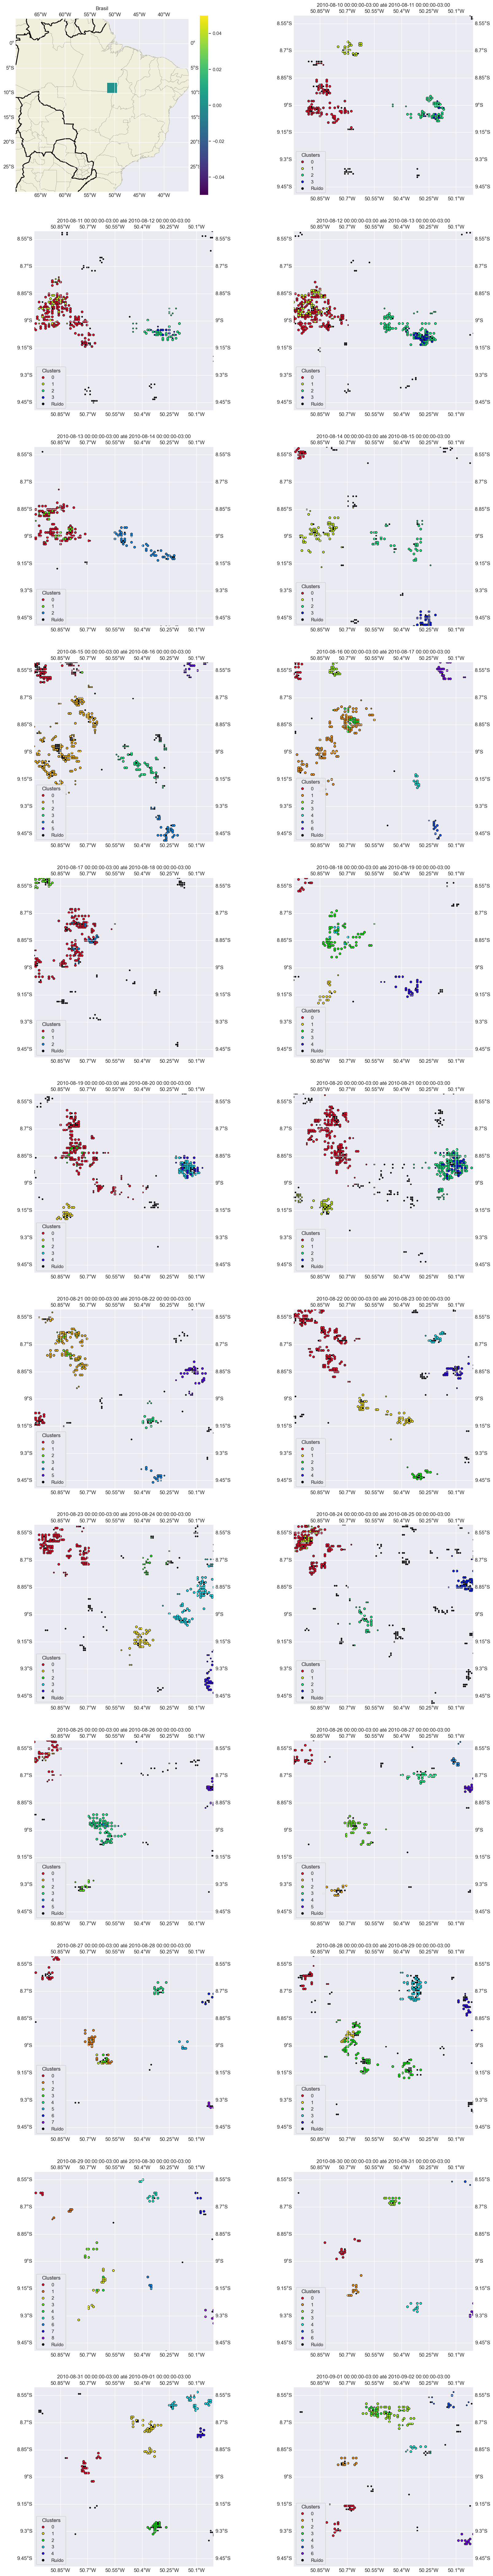

In [443]:
show_time_grid(df, pd.date_range("2010-08-10", freq="1D", periods=25, tz=data_timezone), -9.5, -8.5, -51, -50)

Ploting with 24 Linhas 12 ...


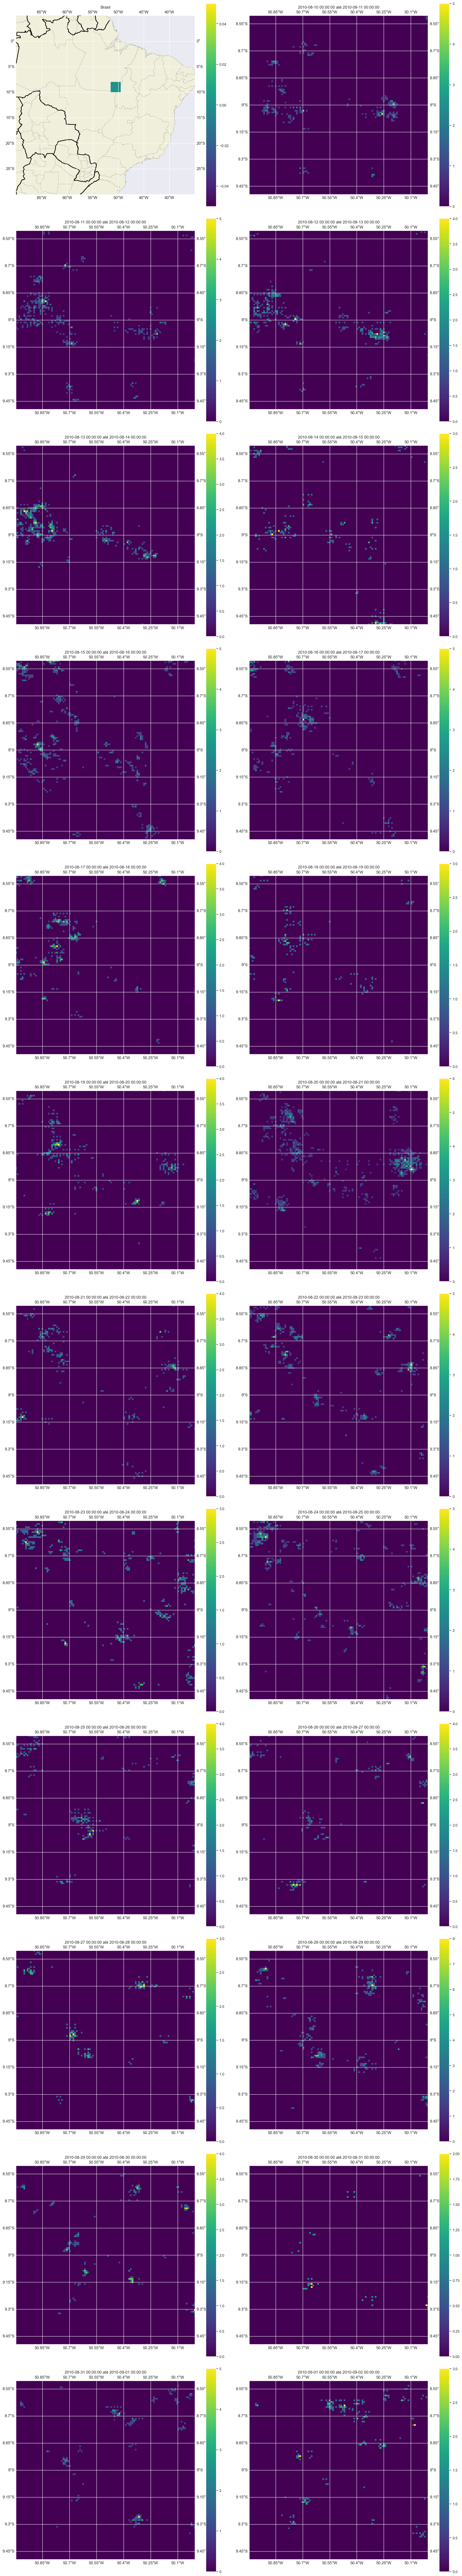

In [454]:
show_time_grid(df, pd.date_range("2010-08-10", freq="1D", periods=25, tz=data_timezone), -9.5, -8.5, -51, -50, show_clusters=True)